# Multiple Correspondence Analysis and Content Analysis

This notebook's aim is to showcase how to conduct Multiple Correspondence Analysis (MCA) on a corpus. In this notebook, we will be using a collection of novels by different authors i.e [_The Return of Sherlock Holmes_](http://www.gutenberg.org/files/221/221-0.txt) by Arthur Conan Doyle, [_Lady Susan_](http://www.gutenberg.org/cache/epub/946/pg946.txt) by Jane Austen, and [_A Christmas Carol_](http://www.gutenberg.org/cache/epub/19337/pg19337.txt) by Charles Dickens taken from [Project Gutenberg](http://www.gutenberg.org).

* First will gather and load in all the text. 
* We clean them and break them down into tokens. 
* We will categorize the tokens using General Inquirer Category taken from Harvard to conduct our analysis. 
* From there we will conduct MCA on the results and plot the results on a scatter plot.

### Library and Resources used

-  Python 3
-  Natural Language Toolkit 
-  Panda
-  Numpy
-  MCA (Multiple Correspondence Analysis)
-  Matplotlib (Plotting)

**Note: ** For installation of the necessary resources and libraries refer to their respective home page for installation steps for your operation system.

Also the novels have some cleaning done to them before their use in the notebook. This involes removing the additional notes made by Gutenberg (inlcuding trademarks, notes about the book, branding) from the start and end of each novel.

Written February, 2018

## Importing the required libraries

In [1]:
# Import helper libraries
import os
import nltk
import csv
import math

# Import panda / panda related content 
import pandas as pd
from pandas import read_table
import numpy as np

# Import MCA and matplot
from mca import *
from matplotlib import pyplot as plt

# Ensure we can see plots inside Jupyter notebook
%matplotlib inline
%load_ext pycodestyle_magic

## Loading in the text

First we need to load in all the required text. In this notebook all the novels are stored in the folder called "Novels". We create two list. One to store the actual content of each novel and the other is to hold the name. This is done so we know that list item/element 0 of the content is from the title found at index/element 0 of the other list. 

In [2]:
# Set path to the file with novels
path = "./Novels"

# Save all the titles of the texts
text_name = []

# Save all the content of the texts
text_content = []

# Go to the directory with all the text files
for filename in os.listdir(path):
    # Add the file name and remove the file type (in this case ".txt")
    text_name.append(filename[:-4])

    # Open each file and add all the content
    with open(path + '/' + filename, "r") as file:
        file_content = file.read()

    # Add the content of the file
    text_content.append(file_content)

## Defining Cleaning and Tokenization Function

Depending on your needs there are varying level of cleaning required. For this notebook we are going to remove any non-words (numbers and punctuation) and set all words to lowercase for simpler analysis. If there is additional or custom cleaning that needs to be done to the corpus, the following function is where you would make these changes.

In [3]:
def cleaning_tokenize_text(text):
    """Define cleaning tokenize function"""
    # Tokenize the text and set it to lower case
    tokens = nltk.word_tokenize(text.lower())

    # Remove all non-words
    tokens = [word for word in tokens if word[0].isalpha()]
    return tokens

## Using the Cleaning Function

Now that we have defined the function that cleans and tokenize the text we are going to apply it to our corpus. 

In [4]:
# List to hold the tokenized results
text_clean_tokenized = []

for novel in text_content:  # Iterate through all the text
    # Add cleaned text into list
    text_clean_tokenized.append(cleaning_tokenize_text(novel))

## Working with General Inquirer Category

Before we can move forward we are going to need to define a few functions and load in the General Inquirer Categories (that can be found here: http://www.wjh.harvard.edu/~inquirer/spreadsheet_guide.htm). 

In this this notebook we will be conducting context analysis on the tokenized and cleaned corpus. This is done by looking at each token and seeing what category (if any) does it belong to outlined in the General Inquirer Categories.

**Note: ** In this notebook we are going to simply the use of the General Inquirer Category. This is because in the General Inquirer Category the have different categories depending on how the word is used. Therefore in this notebook all edition of each word is collapsed into one row that encompass all category each edition possess. 

In [5]:
# The csv name of the inquirer dictionary
csv_file = "inquirerbasic.csv"

# Initialize a list to hold the values
list_of_rows = []

# Reading the csv
with open(csv_file, 'r') as file:
    data = csv.reader(file)

    # For every row in the fie save it
    for row in data:
        list_of_rows.append(row)

# Format the category
categories = list_of_rows[0]

# We do not need the first 2 categories
# (they are labels for Category and Sources)
# The last two columns are description of the words in question.
# Note the csv also as additional 4 empty columns at the end
# Hence -6 on the end slicer.
categories = categories[2:len(categories)-6]

# Check on how many categories
print("Length of category {}".format(len(categories)))

# Print out the first 5 categories
print(categories[:5])

Length of category 182
['Positiv', 'Negativ', 'Pstv', 'Affil', 'Ngtv']


## General Inquirer Category Helper Functions

Below are helper functions that help categorize the tokenized text in the corresponding categories.

In [6]:
def new_attribute_set(row):
    """Set all the categories of a word into a set
    if that word did not exist already
    returns a set which is faster to load than list
    """
    attribute_set = set()

    # If you belong to a category add it into the set
    for element in row:
        if element != "":
            attribute_set.add(element)
    return attribute_set


def combine_attribute_set(row, old_set):
    """Combine with pre-existing set with any new additions"""
    new_set = set()

    # If you belong to a category add it into the set
    for element in row:
        if element != "":
            new_set.add(element)

    # Return a new updated set
    return (old_set | new_set)


def get_dictionary_list(list_of_rows, categories):
    """Assign every word with the categories (in a set)"""
    return_dict = {}

    # For every row create the set of categories that belong to it
    for row in list_of_rows:
        # Reduce the word to the base. This is because the csv
        # has LOVE#1, LOVE#2 to symbolize different meanings,
        # we are going to collapse them together
        word = row[0].split("#", 1)[0]

        # extract categories from second position and
        # exclude the last 2 items
        sliced_categories = row[2:len(categories)-2]

        # Check to see if the word is in the dictionary already
        if word in return_dict:
            return_dict[word] = combine_attribute_set(
                sliced_categories,
                return_dict[word]
            )
        else:
            return_dict[word] = new_attribute_set(sliced_categories)

    return return_dict


def update_values_category(dataframe):
    """Creates the columns we need and fills them with
    how many of each categories the text belongs to"""
    # Finds and counts all the categories it belongs to
    result_dictionary = find_category(dataframe["tokens"])
    # Iterate through the results
    for k, v in result_dictionary.items():
        # Create columns for every category
        dataframe[k] = v
    return dataframe


def find_category(tokens):
    """Looks through the tokens and increments the appropriate
    categories that it belongs to"""
    # Set all categories to 0 by default
    tweet_categories = {el: 0 for el in categories}
    # Iterate through all tokens

    for element in tokens:
        # If it exists increment the value
        if element.upper() in dict_words:
            inside = dict_words[element.upper()]

            # Increment the category
            for element in inside:
                tweet_categories[element] += 1

    return tweet_categories

## Dictionary of General Inquirer Category

Now that we have defined helper functions, we will now create the dictionary of words and their corresponding categories. The reason for this dictionary creation is to help improve performance since looking at every token in a large corpus can take a long time to parse through. Therefore the use of more efficent data structures can save large amount of computational time. 

In [7]:
# Create dictionary of words and their respective categories
dict_words = get_dictionary_list(list_of_rows[1:], categories)

# Have a look at the dictionary
dict_words

{'ABIDE': {'Active', 'Affil', 'Doctrin', 'IAV', 'Positiv'},
 'ABILITY': {'ABS', 'Abs@', 'EVAL', 'MeansLw', 'Positiv', 'Strong', 'Virtue'},
 'ABLE': {'EVAL', 'MeansLw', 'Positiv', 'Pstv', 'Strong', 'Virtue'},
 'ABOUND': {'IAV', 'Increas', 'Passive', 'Positiv'},
 'ABSOLVE': {'Active', 'ComForm', 'IAV', 'Positiv', 'SocRel'},
 'ABSORBENT': {'Increas', 'IndAdj', 'Positiv'},
 'ABSORPTION': {'Affil', 'Increas', 'Positiv'},
 'ABUNDANCE': {'ECON',
  'Ovrst',
  'Positiv',
  'Pstv',
  'Quan',
  'Strong',
  'WltOth',
  'WltTot'},
 'ABUNDANT': {'Ovrst',
  'Positiv',
  'Pstv',
  'Quan',
  'Strong',
  'WltOth',
  'WltTot'},
 'ACCEDE': {'Active',
  'Affil',
  'ComForm',
  'IAV',
  'Positiv',
  'PowGain',
  'PowTot'},
 'ACCENTUATE': {'Active', 'IAV', 'Ovrst', 'Positiv'},
 'ACCEPT': {'IAV', 'Passive', 'PosAff', 'Positiv', 'Pstv', 'SocRel', 'Submit'},
 'ACCEPTABLE': {'EVAL', 'PosAff', 'Positiv', 'Pstv', 'Virtue'},
 'ACCEPTANCE': {'Affil', 'Passive', 'PosAff', 'Positiv', 'Pstv', 'SocRel'},
 'ACCESSIBLE': 

## Setting Up Multiple Correspondence Analysis (MCA)

Now that we have all the components completed it is time to format the data for MCA. To do this we first need to transfer the data from the list we had it before into a panda dataframe. The reason for this is because the panda library provides a lot of nice features for data manipulation.

In [8]:
# Create a dataframe to store all the values
mca_dataframe = pd.DataFrame(index=text_name)

# Insert the tokenized data
mca_dataframe.insert(loc=0, column='tokens', value=text_clean_tokenized)

# Count the number of times each category appears in the text based on the their tokens
mca_dataframe = mca_dataframe.apply(update_values_category, axis=1)

# Remove the tokens frame now that we are done with it
mca_dataframe = mca_dataframe.drop("tokens", axis=1)

# Replace any empty cell with 0
mca_dataframe = mca_dataframe.fillna(0)

# Have a look at what the dataframe looks like
mca_dataframe

,Positiv,Negativ,Pstv,Affil,Ngtv,Hostile,Strong,Power,Weak,Submit,...,PtLw,Nation,Anomie,NegAff,PosAff,SureLw,If,NotLw,TimeSpc,FormLw
The Return of Sherlock Holmes,5228,4563,4879,3966,4047,2837,8704,4693,3816,1471,...,918,219,34,678,963,3373,0,0,0,0
A Christmas Carol,1504,1070,1342,863,930,673,2079,951,999,316,...,266,45,14,157,318,818,0,0,0,0
Lady Susan,1487,956,1316,995,821,496,1791,956,902,336,...,240,40,14,166,244,769,0,0,0,0


## Relative Frequencies

Although having a base count is good, it does not tell us a lot. This is because the novel come in different sizes. Shorter novels will have lower counts, therefore to even the fields, we are going to divide each value by the total count of that row. This gives us a relative frequency for each category.

In [9]:
# Divide each cell by the sum of the row
mca_dataframe.loc[:,:] = mca_dataframe.loc[:,:].div(mca_dataframe.sum(axis=1), axis=0)

# See the results
mca_dataframe

,Positiv,Negativ,Pstv,Affil,Ngtv,Hostile,Strong,Power,Weak,Submit,...,PtLw,Nation,Anomie,NegAff,PosAff,SureLw,If,NotLw,TimeSpc,FormLw
The Return of Sherlock Holmes,0.017948,0.015665,0.016750,0.013616,0.013894,0.009740,0.029881,0.016111,0.013101,0.005050,...,0.003152,0.000752,0.000117,0.002328,0.003306,0.011580,0.0,0.0,0.0,0.0
A Christmas Carol,0.021001,0.014941,0.018739,0.012051,0.012986,0.009398,0.029031,0.013280,0.013950,0.004413,...,0.003714,0.000628,0.000195,0.002192,0.004440,0.011422,0.0,0.0,0.0,0.0
Lady Susan,0.024340,0.015649,0.021541,0.016287,0.013439,0.008119,0.029316,0.015649,0.014765,0.005500,...,0.003929,0.000655,0.000229,0.002717,0.003994,0.012588,0.0,0.0,0.0,0.0


## Multiple Correspondence Analysis

We now use the MCA library to conduct the analysis of our dataframe. There are many different methods and ways to conduct Correspondence Analysis. Depending on the needs of your research, different methods and calculations may be more useful. In this notebook we are trying to recreate something similar to the results found in ["Correspondence Analysis"](https://pdfs.semanticscholar.org/53b9/966a0333c9c9198cdf03efc073e991647c12.pdf) by Herve Abdi and Lynne J. Williams (more accurately figure 7 on page 22).

**Definition: ** Correspondence Analysis is a statistical technique that provides a graphical representation of cross tabulations. Cross tabulations happens when placing events into a set of different categories. For example punctuation use and authorship. 

For a more indepth understanding on the methods, process, and values in the following section refer to the paper mentioned earlier. This is because this notebook is not meant to explain and contrast the different aspects of MCA, but rather showcase how it can be implemented. It is important to note that the results of this correspondence analysis is not a 2D result. For that we need to map it into a 2D plane.

For additional information on MCA and the functionaity it possess go to: https://github.com/esafak/mca and read their testcase (which verifies its results from the paper mentioned above in one of its testcase) and source code.

**Note: ** For the sake of reducing the amount of clutter in the graph later, we will only use the first 10 columns of the dataframe.

In [10]:
# Run MCA on the dataframe (first 10 columns)
mca_test = MCA(mca_dataframe.loc[:,:'Submit'], benzecri=False)

# Acqure the factor score for the Authors
authors_score = mca_test.fs_r().T

# Acqure the factor score for the Categories
category_score = mca_test.fs_c().T

# Returns the variance of each Axis 
variance = mca_test.L

# Calcuate the % variance of total
variance_total = [variance[0] / (variance[0] + variance[1]), variance[1] / (variance[0] + variance[1])]

## Plotting the Points

Now that we have calculated all the points accompanied by the variance for each axis, we can move onto plotting the results.

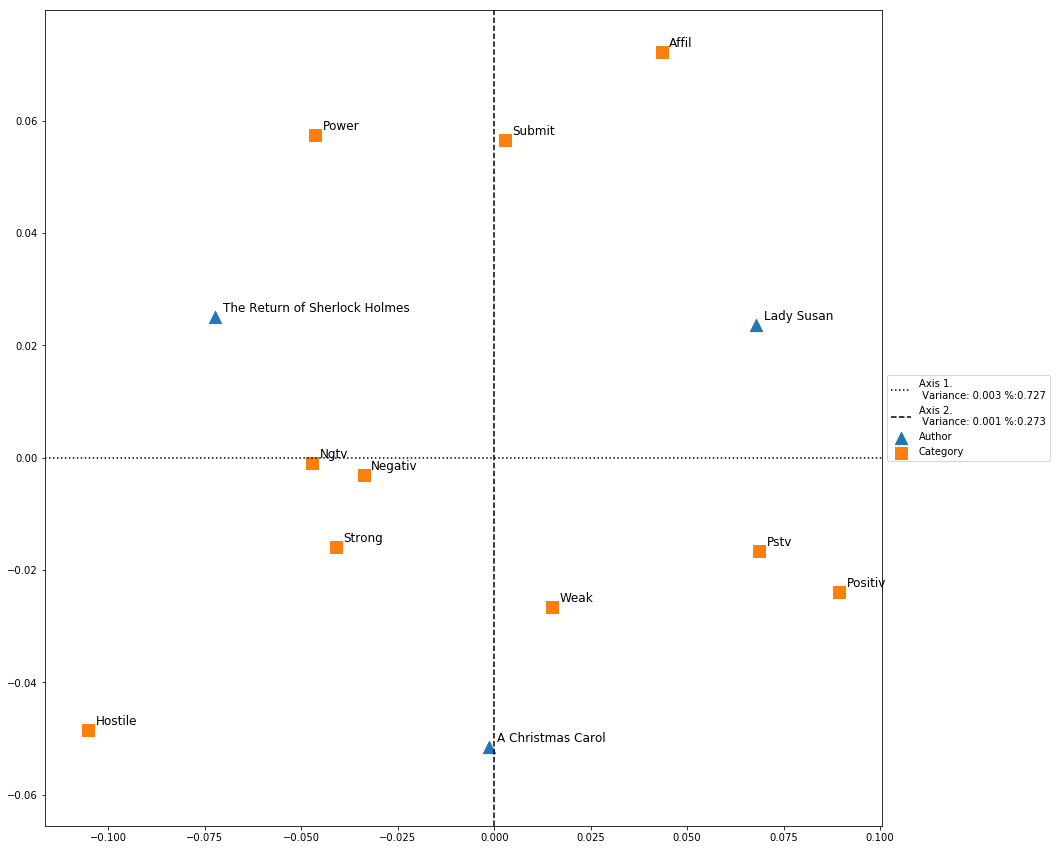

In [11]:
# Set the size of the figure
plt.rcParams["figure.figsize"] = (15,15)

# Set the Author points to be represented by Triangles
plt.scatter(
    authors_score[0], 
    authors_score[1], 
    cmap='viridis', 
    s=150, 
    marker = '^', 
    label='Author'
)

# Set the Category points to be represented by Squares
plt.scatter(
    category_score[0], 
    category_score[1], 
    cmap='viridis', 
    s=150, 
    marker='s', 
    label='Category'
)



name = ["A", "B", "C"]

# Label each point for Author
for i, txt in enumerate(text_name):
    x_adjust = 0.002  # align plot labels
    y_adjust = 0.0009  # align plot labels
    plt.annotate(
        txt,
        (authors_score[0][i]+x_adjust,authors_score[1][i]+y_adjust),
        fontsize=12,
        fontweight='normal'
    )

# Label each point for Category
for i, txt in enumerate(categories[:10]):
    plt.annotate(
        txt, 
        (category_score[0][i]+x_adjust,category_score[1][i]+y_adjust), 
        fontsize=12,
        fontweight='normal'
    )

# Draw axis

Axis1_Label= "Axis 1. \n Variance: {} %:{}".format(format(variance[0], '.3f'), format(variance_total[0], '.3f'))
Axis2_Label= "Axis 2. \n Variance: {} %:{}".format(format(variance[1], '.3f'), format(variance_total[1], '.3f'))
plt.axhline(0, color='black',linestyle=':', label=Axis1_Label)
plt.axvline(0, color='black',linestyle='--', label=Axis2_Label)

# Set Legend
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))    

# Display Graph
plt.show()

## Conclusion 

In this notebook we looked at how to clean and tokenize a corpus for content analysis. Afterwards we showcase how to transform that data into a form for MCA. Finally displaying the results of the MCA. Although this notebook only looks at a single application of MCA or Correspondent analysis, it does demostrate what this type of analysis can do.